# Predicting bank marketing success: an experiment in modelling imbalanced data

In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from datetime import datetime 
from sklearn.externals import joblib
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_curve,roc_auc_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

In [2]:
##create timer func (credit to stackoverflow for this function!)
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

In [ ]:
#Data citation:

#[Moro et al., 2011] S. Moro, R. Laureano and P. Cortez. Using Data Mining for Bank Direct Marketing: 
#An Application of the CRISP-DM Methodology. In P. Novais et al. (Eds.), 
#Proceedings of the European Simulation and Modelling Conference - ESM 2011, pp. 117-121, 
#Guimaraes, Portugal, October, 2011. EUROSIS.

In [ ]:
#Relevant Information:

   #The data is related with direct marketing campaigns of a Portuguese banking institution. 
   #The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, 
   #in order to access if the product (bank term deposit) would be (or not) subscribed. 

   #There are two datasets: 
      #1) bank-full.csv with all examples, ordered by date (from May 2008 to November 2010).
      #2) bank.csv with 10% of the examples (4521), randomly selected from bank-full.csv.
   #The smallest dataset is provided to test more computationally demanding machine learning algorithms (e.g. SVM).

   #The classification goal is to predict if the client will subscribe a term deposit (variable y).

   #Number of Instances: 45211 for bank-full.csv (4521 for bank.csv)

   #Number of Attributes: 16 + output attribute.

   #Attribute information:

   #For more information, read [Moro et al., 2011].

   #Input variables:
   # bank client data:
   #1 - age (numeric)
   #2 - job : type of job (categorical: "admin.","unknown","unemployed","management","housemaid","entrepreneur","student",
                                       #"blue-collar","self-employed","retired","technician","services") 
   #3 - marital : marital status (categorical: "married","divorced","single"; note: "divorced" means divorced or widowed)
   #4 - education (categorical: "unknown","secondary","primary","tertiary")
   #5 - default: has credit in default? (binary: "yes","no")
   #6 - balance: average yearly balance, in euros (numeric) 
   #7 - housing: has housing loan? (binary: "yes","no")
   #8 - loan: has personal loan? (binary: "yes","no")
   # related with the last contact of the current campaign:
   #9 - contact: contact communication type (categorical: "unknown","telephone","cellular") 
  #10 - day: last contact day of the month (numeric)
  #11 - month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")
  #12 - duration: last contact duration, in seconds (numeric)
   # other attributes:
  #13 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
  #14 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric, -1    
    #means client was not previously contacted)
 # 15 - previous: number of contacts performed before this campaign and for this client (numeric)
 # 16 - poutcome: outcome of the previous marketing campaign (categorical: "unknown","other","failure","success")

 # Output variable (desired target):
 # 17 - y - has the client subscribed a term deposit? (binary: "yes","no")

In [3]:
## import
file = 'https://raw.githubusercontent.com/SubotaiJC/scriptz/master/bank-full.csv'
data = pd.read_table(file, sep=";")
data = data.sample(frac=1).reset_index(drop=True) #shuffle
data.rename(columns = {'campaign': 'num_of_calls', 
                       'previous': 'prev_contacts', 
                       'y': 'outcome'}, inplace=True) #rename some columns for interpretability
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,num_of_calls,pdays,prev_contacts,poutcome,outcome
0,32,admin.,married,secondary,no,1078,yes,no,cellular,16,apr,177,1,-1,0,unknown,no
1,45,admin.,married,secondary,no,129,yes,no,cellular,9,sep,307,2,191,1,failure,no
2,31,admin.,single,secondary,no,150,yes,yes,unknown,13,may,431,2,-1,0,unknown,no
3,62,blue-collar,married,secondary,no,272,no,no,cellular,11,aug,146,1,286,2,failure,yes
4,40,unemployed,single,tertiary,no,97,yes,yes,cellular,2,feb,73,1,252,1,failure,no


In [4]:
## data exploration
data.shape #get number of features and rows

(45211, 17)

In [5]:
data.describe(include='all')

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,num_of_calls,pdays,prev_contacts,poutcome,outcome
count,45211.000000,45211,45211,45211,45211,45211.000000,45211,45211,45211,45211.000000,45211,45211.000000,45211.000000,45211.000000,45211.000000,45211,45211
unique,NaN,12,3,4,2,NaN,2,2,3,NaN,12,NaN,NaN,NaN,NaN,4,2
top,NaN,blue-collar,married,secondary,no,NaN,yes,no,cellular,NaN,may,NaN,NaN,NaN,NaN,unknown,no
freq,NaN,9732,27214,23202,44396,NaN,25130,37967,29285,NaN,13766,NaN,NaN,NaN,NaN,36959,39922
mean,40.936210,NaN,NaN,NaN,NaN,1362.272058,NaN,NaN,NaN,15.806419,NaN,258.163080,2.763841,40.197828,0.580323,NaN,NaN
std,10.618762,NaN,NaN,NaN,NaN,3044.765829,NaN,NaN,NaN,8.322476,NaN,257.527812,3.098021,100.128746,2.303441,NaN,NaN
min,18.000000,NaN,NaN,NaN,NaN,-8019.000000,NaN,NaN,NaN,1.000000,NaN,0.000000,1.000000,-1.000000,0.000000,NaN,NaN
25%,33.000000,NaN,NaN,NaN,NaN,72.000000,NaN,NaN,NaN,8.000000,NaN,103.000000,1.000000,-1.000000,0.000000,NaN,NaN
50%,39.000000,NaN,NaN,NaN,NaN,448.000000,NaN,NaN,NaN,16.000000,NaN,180.000000,2.000000,-1.000000,0.000000,NaN,NaN
75%,48.000000,NaN,NaN,NaN,NaN,1428.000000,NaN,NaN,NaN,21.000000,NaN,319.000000,3.000000,-1.000000,0.000000,NaN,NaN


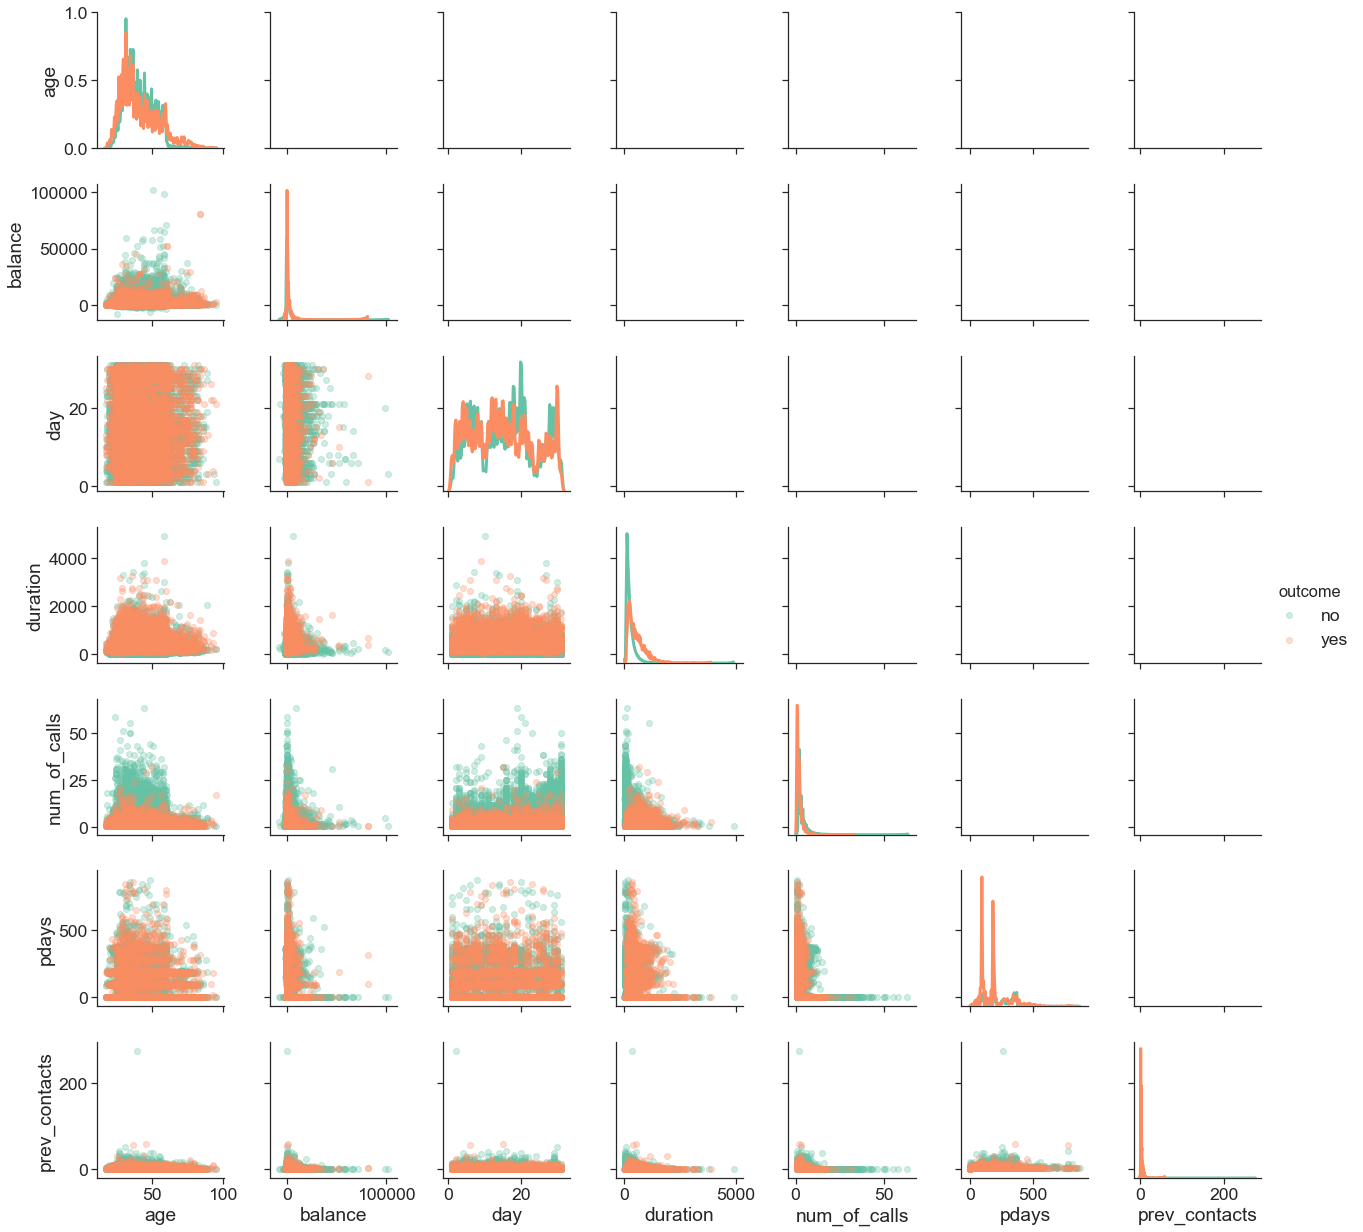

In [6]:
#viz: pairplot
sns.set(font_scale=1.6, style="ticks")

pg = sns.PairGrid(data=data, diag_sharey=False, hue='outcome', 
                  palette='Set2')

pg.map_diag(sns.kdeplot, lw = 3, legend = False, bw=.30)
pg.map_lower(plt.scatter, alpha=0.3)
pg.add_legend()

plt.show()

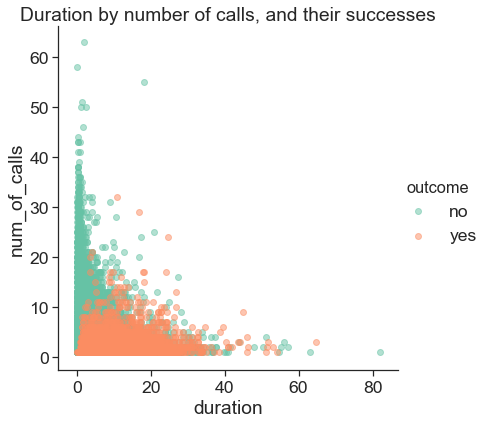

In [7]:
#the relationship between duration and number of calls in the plot above seems interesting. Let's take a closer look

data['duration'] = data['duration'].apply(lambda x:x/60).round(2) #convert duration of calls to minutes

sns.lmplot(x='duration', 
           y='num_of_calls',
           hue = 'outcome',
           palette='Set2',
           data=data, 
           fit_reg = False,
           scatter_kws={'alpha':0.5}, height=6)
plt.title('Duration by number of calls, and their successes') #
plt.show()

In [8]:
data.drop(columns=['prev_contacts'],inplace=True) #dropping previous contacts, as var doesn't tell us much
data.drop(columns=['month','day'],inplace=True) #ignoring time-based effects for sake of simplicity
#data.head()

In [9]:
#taking a look at some categorical vars
data.groupby('job').agg('mean').round(1)

,age,balance,duration,num_of_calls,pdays
job,,,,,
admin.,39.3,1135.8,4.1,2.6,47.9
blue-collar,40.0,1078.8,4.4,2.8,44.0
entrepreneur,42.2,1521.5,4.3,2.8,32.5
housemaid,46.4,1392.4,4.1,2.8,21.5
management,40.4,1763.6,4.2,2.9,38.7
retired,61.6,1984.2,4.8,2.3,37.4
self-employed,40.5,1648.0,4.5,2.9,34.7
services,38.7,997.1,4.3,2.7,42.0
student,26.5,1388.1,4.1,2.3,57.0


In [10]:
data['poutcome'].value_counts()

unknown    36959
failure     4901
other       1840
success     1511
Name: poutcome, dtype: int64

In [11]:
data['contact'].value_counts()

cellular     29285
unknown      13020
telephone     2906
Name: contact, dtype: int64

In [12]:
data.drop(columns = ['contact', 'poutcome'], inplace=True) 
#dropping columns with too many unknown entries

In [13]:
data.groupby('outcome').agg('mean').round(1)

,age,balance,duration,num_of_calls,pdays
outcome,,,,,
no,40.8,1303.7,3.7,2.8,36.4
yes,41.7,1804.3,9.0,2.1,68.7


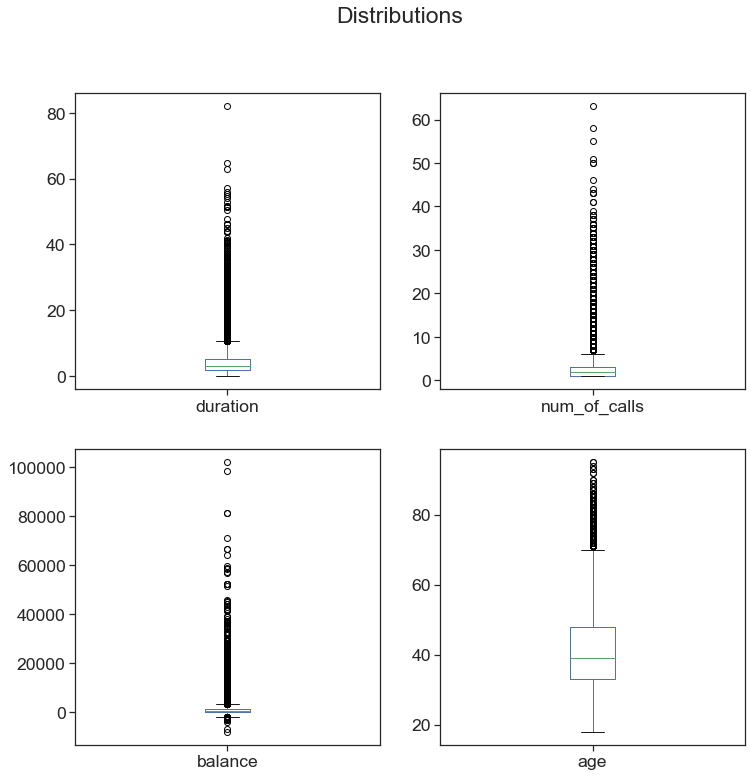

In [14]:
#viz: distribution plots
data[['duration','num_of_calls','balance','age']].plot(kind = 'box',
                                       figsize = (12,12),
                                       subplots = True, layout = (2,2),
                                       sharex = False, sharey = False,
                                       title='Distributions')
plt.show()

#outliers would ideally need to be dealt with first beforing modelling

In [15]:
data['outcome'].value_counts()

no     39922
yes     5289
Name: outcome, dtype: int64

In [16]:
## pre-processing
data.replace(to_replace= ['no','yes'], value = [0,1], inplace=True)
preds = data.drop(['outcome'], axis=1)
target = data['outcome']

encoder = LabelEncoder()
encoder = encoder.fit(target)
target = encoder.transform(target)

preds = pd.get_dummies(preds, prefix_sep='_', drop_first=True) #convenient pandas method for categorical encoding
preds.head(5)

,age,default,balance,housing,loan,duration,num_of_calls,pdays,job_blue-collar,job_entrepreneur,...,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_married,marital_single,education_secondary,education_tertiary,education_unknown
0,32,0,1078,1,0,2.95,1,-1,0,0,...,0,0,0,0,0,1,0,1,0,0
1,45,0,129,1,0,5.12,2,191,0,0,...,0,0,0,0,0,1,0,1,0,0
2,31,0,150,1,1,7.18,2,-1,0,0,...,0,0,0,0,0,0,1,1,0,0
3,62,0,272,0,0,2.43,1,286,1,0,...,0,0,0,0,0,1,0,1,0,0
4,40,0,97,1,1,1.22,1,252,0,0,...,0,0,0,1,0,0,1,0,1,0


In [17]:
scaler = StandardScaler() #scaling pred vars
scaled_preds = scaler.fit_transform(preds,)
preds_df = pd.DataFrame(scaled_preds, index=data.index, columns=preds.columns)

In [19]:
#train/test split (80/20)
X_train, X_test, y_train, y_test = train_test_split(preds_df, target, test_size=0.20, random_state=20)

print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

(36168, 24) (36168,)
(9043, 24) (9043,)


# Logistic Regression

In [21]:
## Specify-Compile
model_LR1 = LogisticRegression(dual = False, 
                               penalty = 'l2')

params = {
        'max_iter': [200,400,600,800],
        'C' : [.01, 0.5, 1] #a penalization term, inverse of lambda so smaller values = more regularization
         }

randomSearch_LR1 = RandomizedSearchCV(model_LR1,param_distributions=params,
                                   cv = 5,
                                   n_iter=20,
                                   n_jobs=-1,
                                   refit = True,
                                   verbose = 0,
                                   random_state = 1205)

In [22]:
## fit
start_time = timer(None) # timing starts
randomSearch_LR1.fit(X_train, y_train)
timer(start_time) # timing ends


 Time taken: 0 hours 0 minutes and 4.69 seconds.


In [24]:
print(randomSearch_LR1.best_params_) #model with best params found via random search

{'max_iter': 200, 'C': 1}


In [26]:
# Addressing class imbalance via SMOTE (over-sampling of minority class)
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state = 2468)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train.ravel())

randomSearch_LR2 = RandomizedSearchCV(model_LR1,param_distributions=params,
                                   cv = 5,
                                   n_iter=20,
                                   n_jobs=-1,
                                   refit = True,
                                   verbose = 0,
                                   random_state = 1304)

#fit
start_time = timer(None)
randomSearch_LR2.fit(X_train_res, y_train_res)
timer(start_time)


 Time taken: 0 hours 0 minutes and 4.38 seconds.


In [27]:
print(randomSearch_LR2.best_params_)

{'max_iter': 200, 'C': 0.01}


In [38]:
# pickle models with best params
LR1 = "LogisticReg.pkl" 
LR2 = "LogisticRegSMOTE.pkl"

best_model_LR1 = randomSearch_LR1.best_estimator_
best_model_LR2 = randomSearch_LR2.best_estimator_

joblib.dump(best_model_LR1, LR1)
joblib.dump(best_model_LR2, LR2)

['LogisticRegSMOTE.pkl']

# Random Forest

In [29]:
# Specify-Compile
model_RF = RandomForestClassifier(criterion='entropy')

params_RF = {
            'max_features' :['sqrt','log2'], 
            'max_depth': [10,12,14,16]
            }  

randomSearch_RF = RandomizedSearchCV(model_RF,param_distributions=params_RF, 
                                   cv = 5,
                                   n_jobs=-1,
                                   refit = True,
                                   return_train_score=True,
                                   verbose = 0,
                                   random_state = 5074)

In [30]:
#fit
start_time = timer(None) 
randomSearch_RF.fit(X_train_res, y_train_res)
timer(start_time) 


 Time taken: 0 hours 1 minutes and 43.43 seconds.


In [31]:
print(randomSearch_RF.best_params_)

{'max_features': 'sqrt', 'max_depth': 16}


In [32]:
# pickle model with best params
RF = "RandomForest.pkl" 
best_model_RF = randomSearch_RF.best_estimator_
joblib.dump(best_model_RF, RF)

['RandomForest.pkl']

# XGBoost

In [33]:
#to derive scale_pos_weight, a hyperparameter that controls the degree of 'cost sensitiveness' wrt misclassification
neg = np.array(np.unique(y_train, return_counts=True))[1,0]
pos = np.array(np.unique(y_train, return_counts=True))[1,1]
sp_weight = neg/pos

model_XGB = xgb.XGBClassifier(objective='binary:logistic', 
                              tree_method = 'hist',
                              scale_pos_weight=sp_weight, 
                              n_estimators=1000)
params = {
            'eta': [0.001,0.01,0.1], 
            'max_depth': [6,7,8],
            'gamma': [1,2,3],
            'reg_alpha': [0,1,2],
            'reg_lambda': [1,2,3],    
            'subsample': [.5,.75, 1]
         }

randomSearch_XGB = RandomizedSearchCV(model_XGB,param_distributions=params, 
                                   scoring = 'roc_auc',
                                   cv = 3,
                                   n_iter=30,
                                   n_jobs=-1,
                                   refit = True,
                                   verbose = 0,
                                   random_state = 2054, 
                                   return_train_score=True)

In [34]:
#fit
start_time = timer(None) 
randomSearch_XGB.fit(X_train, y_train)
timer(start_time) 


 Time taken: 0 hours 7 minutes and 55.37 seconds.


In [35]:
print(randomSearch_XGB.best_params_)

{'subsample': 1, 'reg_lambda': 3, 'reg_alpha': 2, 'max_depth': 7, 'gamma': 3, 'eta': 0.01}


In [36]:
# pickle model1 with best params
XGB = "XGB.pkl" 
best_model_XGB = randomSearch_XGB.best_estimator_
joblib.dump(best_model_XGB, XGB)

['XGB.pkl']

# Evaluating models

In [39]:
LogisticReg = joblib.load('LogisticReg.pkl')
LogisticRegSMOTE = joblib.load('LogisticRegSMOTE.pkl')
RandomForest = joblib.load('RandomForest.pkl')
XGBoost = joblib.load('XGB.pkl')

In [43]:
#get model scores
for model in (LogisticReg, LogisticRegSMOTE,RandomForest, XGBoost):
    y_pred = model.predict(X_test) 
    name =[x for x in globals() if globals()[x] is model][0]
    preds = model.predict(X_test)
    print('%s Accuracy: %2f' % (name, accuracy_score(y_test, preds)))
    print('%s Precision: %2f' % (name, precision_score(y_test, preds)))
    print('%s Recall: %2f' % (name, recall_score(y_test, preds)))
    print('%s F1 score: %2f' % (name, f1_score(y_test, preds)))
    print(3*'-')    

LogisticReg Accuracy: 0.898596
LogisticReg Precision: 0.581769
LogisticReg Recall: 0.221881
LogisticReg F1 score: 0.321244
---
LogisticRegSMOTE Accuracy: 0.797412
LogisticRegSMOTE Precision: 0.320135
LogisticRegSMOTE Recall: 0.777096
LogisticRegSMOTE F1 score: 0.453461
---
RandomForest Accuracy: 0.851377
RandomForest Precision: 0.393975
RandomForest Recall: 0.695297
RandomForest F1 score: 0.502959
---
XGBoost Accuracy: 0.839213
XGBoost Precision: 0.376556
XGBoost Recall: 0.742331
XGBoost F1 score: 0.499656
---


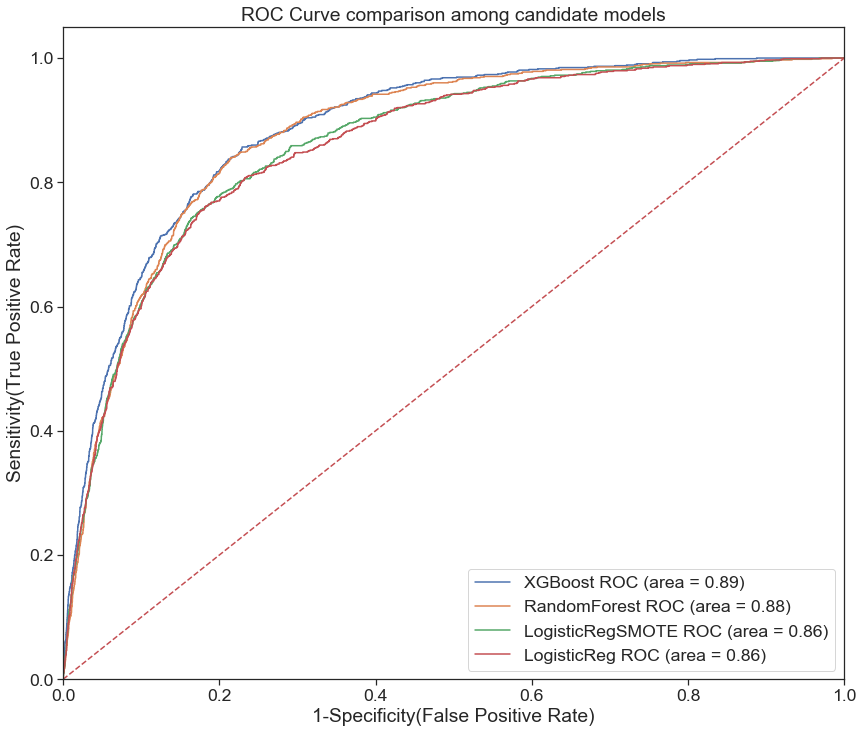

In [48]:
#plot ROC (or AUROC) curve, which shows the ability of each model to correctly discriminate between binary classes
plt.figure(figsize=(14,12))

for model in (XGBoost, RandomForest, LogisticRegSMOTE, LogisticReg):
    y_pred = model.predict(X_test) # predict the test data
    name =[x for x in globals() if globals()[x] is model][0]
# Compute False postive rate, True positive rate
    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
# Calculate AUC
    auc = roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
# Plot values
    plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (name, auc))
# Customize
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('ROC Curve comparison among candidate models')
plt.legend(loc="best")
plt.show()

In [ ]:
##Given the imbalanced sample and nature of the business question, 
#I would consider the precision-recall tradeoff via the F1 score,
#and thus opt for XGBoost or RandomForest